In [50]:
import csv
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import math
from dataclasses import dataclass
from absl import logging
logging.set_verbosity(logging.ERROR)

In [51]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [52]:
def parse_data_from_file(filename):
    
    times = []
    temperatures = []

    with open(filename) as csvfile:
        
        ### START CODE HERE
        
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        temp=0
        for row in reader:
            temperatures.append(float(row[1]))
            times.append(temp)
            temp+=1
        times=np.array(times)
        temperatures=np.array(temperatures)
        ### END CODE HERE
            
    return times, temperatures

In [53]:
# Test your function and save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    TEMPERATURES_CSV = 'Cakalang-14c.csv'
    times, temperatures = parse_data_from_file(TEMPERATURES_CSV)
    TIME = np.array(times)
    SERIES = np.array(temperatures)
    SPLIT_TIME = math.floor(0.75*1828)
    WINDOW_SIZE = 180
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 10


# plt.figure(figsize=(10, 6))
# plot_series(G.TIME, G.SERIES)
# plt.show()

In [54]:
print(G.SERIES)

[29500. 29500. 29500. ... 41500. 41500. 41500.]


In [55]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_train0, time_valid, series_valid0 = train_val_split(G.TIME, G.SERIES)

In [56]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# model=scaler.fit((time_train,series_train))
# time_train,series_train=model.transform((time_train,series_train))
# model2=scaler.fit((time_valid,series_valid))
# time_valid,series_valid=model2.transform((time_valid,series_valid))

In [57]:
series_train=(series_train0-np.min(series_train0))/(np.max(series_train0)-np.min(series_train0))
series_valid=(series_valid0-np.min(series_valid0))/(np.max(series_valid0)-np.min(series_valid0))

In [58]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds


# Apply the transformation to the training set
train_set = windowed_dataset(series_train, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

In [59]:
def create_uncompiled_model():

    ### START CODE HERE
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=8, kernel_size=4,
                               strides=1,
                               activation='relu',
                               padding='causal',
                               input_shape=[G.WINDOW_SIZE,1]),
        tf.keras.layers.Dropout(0.4),
        # tf.keras.layers.LSTM(512, return_sequences=True),
        # # tf.keras.layers.LSTM(256),
        # tf.keras.layers.Conv1D(filters=512, kernel_size=4,
        #                        strides=1,
        #                        activation='relu',
        #                        padding='causal'),
        # tf.keras.layers.LSTM(256, return_sequences=True),
        # # tf.keras.layers.LSTM(128),
        # tf.keras.layers.Conv1D(filters=256, kernel_size=4,
        #                        strides=1,
        #                        activation='relu',
        #                        padding='causal'),
        # tf.keras.layers.LSTM(128, return_sequences=True),
        # # tf.keras.layers.LSTM(64),
        # tf.keras.layers.Conv1D(filters=512, kernel_size=4,
        #                        strides=1,
        #                        activation='relu',
        #                        padding='causal'),
        # tf.keras.layers.LSTM(256, return_sequences=True),
        # # tf.keras.layers.LSTM(128),
        # tf.keras.layers.Conv1D(filters=64, kernel_size=4,
        #                        strides=1,
        #                        activation='relu',
        #                        padding='causal'),
        # tf.keras.layers.LSTM(128, return_sequences=True),
        # # tf.keras.layers.LSTM(64),
        # tf.keras.layers.Conv1D(filters=32, kernel_size=4,
        #                        strides=1,
        #                        activation='relu',
        #                        padding='causal'),
        tf.keras.layers.LSTM(8, return_sequences=True),
        tf.keras.layers.LSTM(4),
        tf.keras.layers.Dropout(0.4),                                        
        # tf.keras.layers.Dense(512, activation='relu'),
        # tf.keras.layers.Dense(256, activation='relu'),
        # tf.keras.layers.Dense(256, activation='relu'),
        # tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dropout(0.4),                
        tf.keras.layers.Dense(1)
    ]) 
    
    ### END CODE HERE

    return model

In [60]:
def adjust_learning_rate(dataset):
    
    model = create_uncompiled_model()
    
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))
    
    ### START CODE HERE
    
    # Select your optimizer
    optimizer = tf.keras.optimizers.Adam()
    
    # Compile the model passing in the appropriate loss
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer, 
                  metrics=["mae"]) 
    
    ### END CODE HERE
    
    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])
    
    return history

In [61]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate(train_set)

Epoch 1/100
38/38 [==============================] - 16s 257ms/step - loss: 0.0938 - mae: 0.3835 - lr: 1.0000e-04
Epoch 2/100
33/38 [=========================>....] - ETA: 1s - loss: 0.0692 - mae: 0.3224

(0.0001, 1.0, 0.0, 1.0)

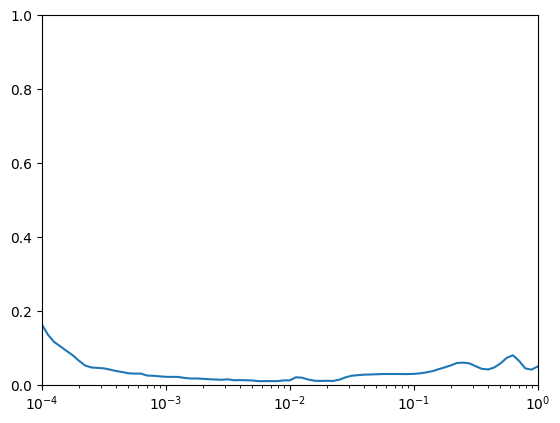

In [ ]:
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([1e-4, 1, 0, 1])

In [ ]:
def create_model():

    
    model = create_uncompiled_model()

    ### START CODE HERE

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.Adam(lr=0.0071),
                  metrics=["mae"])  
    

    ### END CODE HERE

    return model

In [ ]:
# Save an instance of the model
model = create_model()

# Train it
history = model.fit(train_set, epochs=50)

Epoch 1/50
38/38 [==============================] - 7s 88ms/step - loss: 0.0548 - mae: 0.2791
Epoch 2/50
38/38 [==============================] - 3s 89ms/step - loss: 0.0432 - mae: 0.2337
Epoch 3/50
38/38 [==============================] - 3s 87ms/step - loss: 0.0377 - mae: 0.2168
Epoch 4/50
38/38 [==============================] - 3s 85ms/step - loss: 0.0315 - mae: 0.1929
Epoch 5/50
38/38 [==============================] - 3s 87ms/step - loss: 0.0257 - mae: 0.1759
Epoch 6/50
38/38 [==============================] - 3s 86ms/step - loss: 0.0223 - mae: 0.1573
Epoch 7/50
38/38 [==============================] - 3s 85ms/step - loss: 0.0179 - mae: 0.1447
Epoch 8/50
38/38 [==============================] - 3s 86ms/step - loss: 0.0179 - mae: 0.1434
Epoch 9/50
38/38 [==============================] - 3s 89ms/step - loss: 0.0168 - mae: 0.1368
Epoch 10/50
38/38 [==============================] - 3s 88ms/step - loss: 0.0158 - mae: 0.1312
Epoch 11/50
38/38 [==============================] - 3s 87m

In [ ]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

52/52 [==============================] - 1s 23ms/step


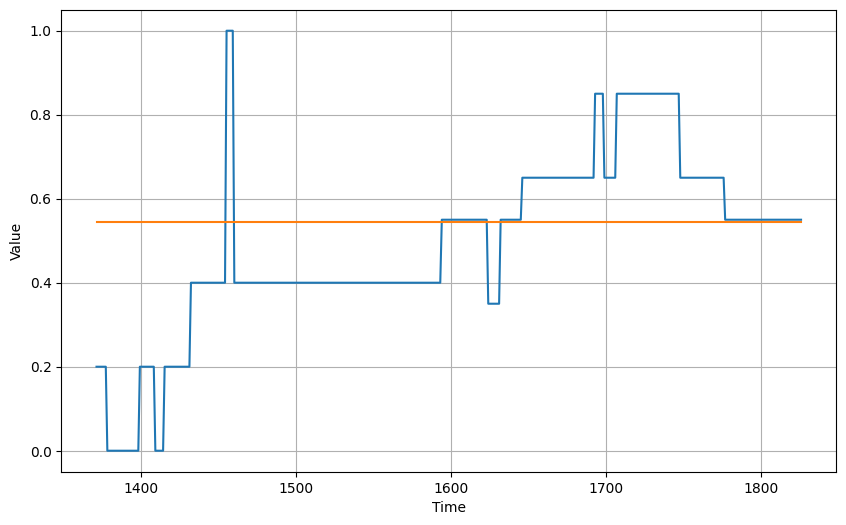

In [ ]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]
# rnn_forecast=rnn_forecast*(np.max(series_valid0)-np.min(series_valid0))+np.min(series_valid0)

# Plot the forecast
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
rnn_forecast=rnn_forecast*(np.max(series_valid0)-np.min(series_valid0))+np.min(series_valid0)


In [ ]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 0.05, mae: 0.17 for forecast
